In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
import sdeint

%matplotlib inline

# Perfect and Near-Perfect Adaptation in Cell Signalling

En un contexto de señalización celular, la adaptación es una propiedad por la cual el sistema es capaz de recuperar su estado inicial/basal tras recibir un estímulo y emitir una señal. El objetivo del paper es tratar de entender cuáles son los motivos de red o las interacciones que se deben dar entre las entidades (las proteínas y los genes) para constituir un sistema con esta capacidad adaptativa. Los sistemas descritos son el Negative Feecback, Incoherent Feed-Forward, State-Dependent Inactivation y **Antithetical Integral Feedback**.

## Antithetical Integral Feedback

El sistema de retroalimentación integral antitética fue desarrollado por Corentin Briat y otros colaboradores en una publicación en Cell Systems del año 2016. Partieron de un sistema de retroalimentación negativa sencillo, como el explicado en el primer apartado, y le añadieron una serie de modificaciones para obtener un sistema de retroalimentación negativa integral. Estos sistemas (integral feedback) tienen una propiedad que los caracteriza, y es que la fuerza de la retroalimentación es proporcional a la integral matemática sobre el tiempo (de ahí su nombre) de la diferencia entre el estado basal (set point) y el estado del momento.

(Wenzhe Ma y colaboradores publicaron también en Cell, en el año 2009, un sistema de retroalimentación negativa integral, pero tenía el inconveniente de que el rango de parámetros en el que funcionaba era muy reducido.)

Aplicaron su modelo a un contexto de expresión génica. Así el sistema sería el siguiente: Un factor de transcripción D favorece la síntesis de un mRNA A, el cual se traduce para dar lugar a la proteína B, que es considerado el "output" / la señal. Además de ser el output, la proteína B es un factor de transcripción que favorece la expresión de la proteína represora C, la cual se une al factor de trancripción D para inhibirlo de manera irreversible. La acción antagónica de las proteínas D y C es el motivo por el que a este sistema se le conoce como "antitético".

### Formalización del modelo

Para la modelización de este sistema se emplearon 4 ecuaciones diferenciales ordinarias y 6 constantes cinéticas. La velocidad de las reacciones/interacciones se expresó asumiendo la cinética de acción de masas.

El conjunto de reacciones consideradas fue:

$$
\begin{align}
&D \overset{k_1}{\longrightarrow} A \\
&A \overset{k_2}{\longrightarrow} \varnothing \\
&A + Input \overset{k_3}{\longrightarrow} B \\
&B \overset{k_4}{\longrightarrow} \varnothing \\
&B \overset{k_4}{\longrightarrow} C \\
&C + D \overset{k_5}{\longrightarrow} \varnothing \\
&\varnothing \overset{k_6}{\longrightarrow} D \\
\end{align}
$$

Las ecuaciones diferenciales que gobiernan el sistema serían:

$$
\begin{align}
\frac{dA}{dt} &= k_1 \cdot D - k_2 \cdot A \\ 
\frac{dB}{dt} &= k_3 \cdot Input \cdot A - k_4 \cdot B \\
\frac{dC}{dt} &= k_4 \cdot B- k_5 \cdot C \cdot D \\
\frac{dD}{dt} &= k_6 - k_5 \cdot C \cdot D \\
\end{align}
$$

A continuación vemos:

- Comprobar evolución del sistema con sucesivos cambios en el input (Repetir Simulación del Paper)


- Estudiar el sistema cambiando la posición donde actúa el input:
    - Sobre la Traducción (k3) --> Paper
    - Sobre la Transcripción (k1) -- > Interaccionando con D para producir A (k1)
    - Sobre la degradación del mRNA (k2)
    - Sobre la degradación de proteina B (k4)
    
    
- Simulación estocástica. Comprobar si desaparecen los ciclos de los casos en los que el Input actúa sobre
  el mRNA y la proteína B


- Estudiar cambios de las constantes cinéticas en el sistema:
    - Estudiar el sistema cambiando los 4 parámetros modificables (k1, k2, k3 y k5)
    - Estudiar el sistema cambiando k4 y k6 y ver su efecto sobre el set point/ estado basal del sistema
    

- Ejemplos en Biología

### Simulación del Paper

Primero fijamos los valores de las constantes cinéticas

In [2]:
k1 = 1
k2 = 3
k3 = 2
k4 = 1
k5 = 50
k6 = 1

Establecemos los valores iniciales de las variables (A, B, C, D, Input) considerando el sistema en equilibrio. Para ello, igualamos las ecuaciones diferenciales a 0. Como tenemos más variables que ecuaciones fijamos B = 1 y Input = 0.5, basándonos en las imágenes del paper. Resolviendo el sistema calculamos que A = 1, D = 3 y C = 1/150 = 0.0067.

In [3]:
A0 = 1
B0 = 1
C0 = 1/150 # Para no perder decimales
D0 = 3
Input = 0.5

u0 = [A0, B0, C0, D0]
p = [Input, k1, k2, k3, k4, k5, k6]

Tiempo de la simulación

In [4]:
tspan = (0.0, 200.0)
timestep = 0.01
time = np.linspace(tspan[0], tspan[1], int(1 + (tspan[1]-tspan[0])/timestep))

Definir función con las ecuaciones diferenciales que gobiernan el sistema

In [5]:
def ODE_Paper(u, t, Input, k1, k2, k3, k4, k5, k6):
    A, B, C, D = u
    
    dA = k1 * D - k2 * A
    dB = k3 * Input * A - k4 * B
    dC = k4 * B - k5 * C * D
    dD = k6 - k5 * C * D
    
    return np.array([dA, dB, dC, dD])

El Input funciona como una constante en la función anterior. No obstante, su valor cambia a lo largo de una simulación completa, por lo que realizaremos la simulación por partes. Creamos una función que concatena simulaciones para valores distintos de Input. Los valores iniciales de cada simulación concatenada serán los valores finales de la simulación previa

In [6]:
def Simul_Concatenate(SDE = False, ODE_func = ODE_Paper, Input_arr = [(0.5, 0)], u0 = u0, \
                      p = p, tspan = tspan, timestep = timestep):
    """La función recibe:
            - Función con ecuaciones diferenciales que pasaremos a odeint
            - Una lista de pares. Cada par tiene el valor del Input y el tiempo donde empieza ese valor
            - Valores iniciales de las variables
            - Lista con los parámetros
            - Tupla con tiempo inicial y final
            - Incremento de tiempo empleado en la simulación
        La función devuelve una matriz con los valores de las variables tras todas las simulaciones
    """
            
    for n, simul in enumerate(Input_arr):
        Input_i, time0_i = simul
        
        # Tiempo final tomado de la siguiente tupla, o del final global
        if n + 1 < len(Input_arr):
            timef_i = Input_arr[n+1][1]
            time_i = np.linspace(time0_i, timef_i, int(1 + (timef_i-time0_i)/timestep))[:-1]
        else:
            timef_i = tspan[1]
            time_i = np.linspace(time0_i, timef_i, int(1 + (timef_i-time0_i)/timestep))
        
        # Tomamos valores iniciales de las variables. Si es la primera
        # iteración, se toman los dados a la función
        if n == 0:
            u0_i = u0.copy()
        else:
            if SDE:
                u0_i = list(sol_glob[-1, :])[:-1]
            else:
                u0_i = list(sol_glob[-1, :])
            
        # Incorporamos a la lista de parámetros el nuevo Input
        pi = p.copy()
        pi[0] = Input_i

        # Hacemos sub-simulación
        if SDE:           
            u0_i.append(Input_i)
            sol_simul_i = sdeint.itoint(ODE_func, NoiseFunction, np.array(u0_i), time_i)
        else:
            sol_simul_i = odeint(func=ODE_func, t = time_i, y0=u0_i, args = tuple(pi))
        
        # Añadimos los resultados a la matriz
        if n == 0:
            sol_glob = np.array(sol_simul_i)
            Input_glob = Input_i * np.ones_like(time_i)
        else:
            sol_glob = np.vstack((sol_glob, sol_simul_i))
            Input_i_vec = Input_i * np.ones_like(time_i)
            Input_glob = np.hstack((Input_glob, Input_i_vec))
            
    return np.hstack((sol_glob, np.reshape(Input_glob, (Input_glob.shape[0], 1))))
            

Hacemos la simulación

In [7]:
# Input_values = [(Input0, t0), (Input1, t1)...]
Input_values = [(0.5, 0), (1, 40), (1.5, 80), (1, 120), (0.5, 160)]

sol_paper = Simul_Concatenate(ODE_func = ODE_Paper, Input_arr = Input_values, \
                              u0 = u0, p = p, tspan = tspan, timestep = timestep)

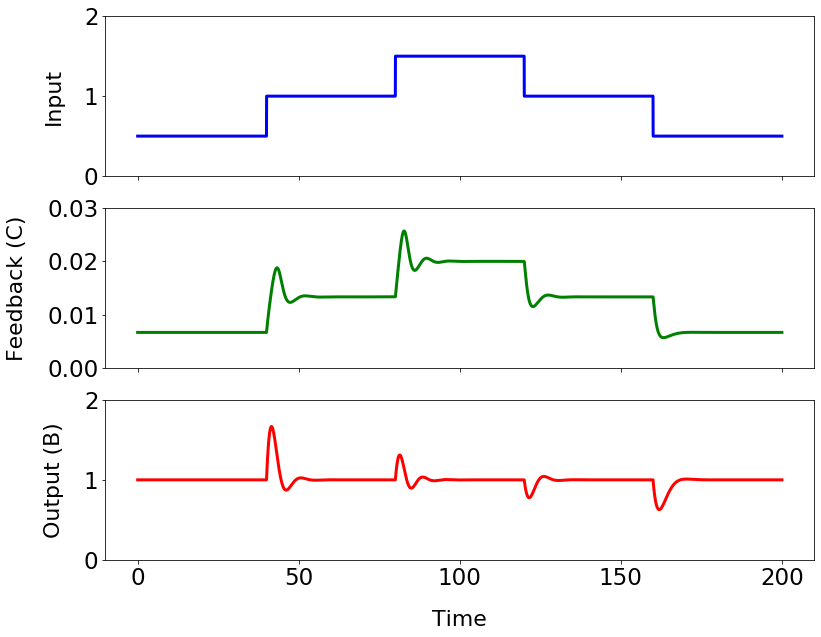

In [8]:
fig, ax = plt.subplots(3, 1, figsize = (12.7, 10))

#ax[0].set_title('Paper Simulation for Antithetical Integral Feedback', fontsize = 20)

ax[0].plot(time, sol_paper[:, 4], 'b', linewidth=3)
#ax[0].set_frame_on(50)

ax[0].set_xticks([0, 50, 100, 150, 200])
ax[0].set_xticklabels( () )

ax[0].set_ylim(0, 2)
ax[0].set_yticks([0, 1, 2])
plt.setp(ax[0].get_yticklabels(), fontsize=23)

ax[0].set_ylabel('Input', fontsize = 22, labelpad = 20)

####
ax[1].plot(time, sol_paper[:, 2], 'g', linewidth=3)

ax[1].set_xticks([0, 50, 100, 150, 200])
ax[1].set_xticklabels( () )

ax[1].set_ylim(0, 0.03)
ax[1].set_yticks([0, 0.01, 0.02, 0.03])
plt.setp(ax[1].get_yticklabels(), fontsize=23)

ax[1].set_ylabel('Feedback (C)', fontsize = 22, labelpad = 20)

####
ax[2].plot(time, sol_paper[:, 1], 'r', linewidth=3)

ax[2].set_xticks([0, 50, 100, 150, 200])

ax[2].set_ylim(0, 2)
ax[2].set_yticks([0, 1, 2])
plt.setp(ax[2].get_yticklabels(), fontsize=23)


plt.setp(ax[2].get_xticklabels(), fontsize=23)
ax[2].set_ylabel('Output (B)', fontsize = 22, labelpad = 20)

'''ax[3].plot(time, sol_paper[:, 0], 'm')
ax[3].set_ylabel('A', fontsize = 16)

ax[4].plot(time, sol_paper[:, 3], 'm')
ax[4].set_ylabel('D', fontsize = 16)'''
_ = ax[2].set_xlabel('Time', fontsize = 22, labelpad = 20)

Como vemos, los resultados obtenidos en la simulación son iguales a los observados en la publicación. El incremento en el Input, produce un aumento temporal en la cantidad de B (output), que inmediatamente se ve amortiguado, volviendo a su estado basal inicial. El aumento de B provoca un incremento proporcional en C (Feedback) que hace que se reduzcan las cantidades de D y A, haciendo que B vuelva a su estado basal. Las reducciones en el Input tienen un efecto similar al incremento, pero produciendo una reducción temporal en el output.

### Estudiar sistema cambiando lugar de actuación del Input

**Interacción con D para dar A (k1)**

Primero consideramos un caso en el que el Input interacciona con el factor de transcripción D para dar lugar al mRNA A. Por lo tanto, las reacciones ahora serían:

$$
\begin{align}
&D + Input \overset{k_1}{\longrightarrow} A \\
&A \overset{k_2}{\longrightarrow} \varnothing \\
&A \overset{k_3}{\longrightarrow} B \\
&B \overset{k_4}{\longrightarrow} \varnothing \\
&B \overset{k_4}{\longrightarrow} C \\
&C + D \overset{k_5}{\longrightarrow} \varnothing \\
&\varnothing \overset{k_6}{\longrightarrow} D \\
\end{align}
$$

Las ecuaciones diferenciales que gobiernan el sistema serían:

$$
\begin{align}
\frac{dA}{dt} &= k_1 \cdot Input \cdot D - k_2 \cdot A \\ 
\frac{dB}{dt} &= k_3 \cdot A - k_4 \cdot B \\
\frac{dC}{dt} &= k_4 \cdot B- k_5 \cdot C \cdot D \\
\frac{dD}{dt} &= k_6 - k_5 \cdot C \cdot D \\
\end{align}
$$

Al cambiar las ecuaciones diferenciales, los valores iniciales establecidas antes para las variables ya no son de equilibrio. De nuevo fijamos B = 1 e Input = 0.5. A partir de ahí, recalculamos los valores de A, C y D para que el sistema esté en el equilibrio. Obtenemos A = 0.5, D = 3 y C = 0.0067. Con respecto al anterior, solo cambia el valor de A.

In [9]:
A0 = 0.5
B0 = 1
C0 = 1/150 # Para no perder decimales
D0 = 3
Input = 0.5

u0 = [A0, B0, C0, D0]
p = [Input, k1, k2, k3, k4, k5, k6]

Tiempo de simulación

In [10]:
tspan = (0.0, 200.0)
timestep = 0.5
time = np.linspace(tspan[0], tspan[1], int(1 + (tspan[1]-tspan[0])/timestep))

Definimos la nueva función con las ecuaciones diferenciales

In [11]:
def ODE_Input_k1(u, t, Input, k1, k2, k3, k4, k5, k6):
    A, B, C, D = u
    
    dA = k1 * Input * D - k2 * A
    dB = k3 * A - k4 * B
    dC = k4 * B - k5 * C * D
    dD = k6 - k5 * C * D
    
    return np.array([dA, dB, dC, dD])

Hacemos la simulación

In [12]:
# Input_values = [(Input0, t0), (Input1, t1)...]
Input_values = [(0.5, 0), (1, 40), (1.5, 80), (1, 120), (0.5, 160)]

sol_input_k1 = Simul_Concatenate(ODE_func = ODE_Input_k1, Input_arr = Input_values, \
                              u0 = u0, p = p, tspan = tspan, timestep = timestep)

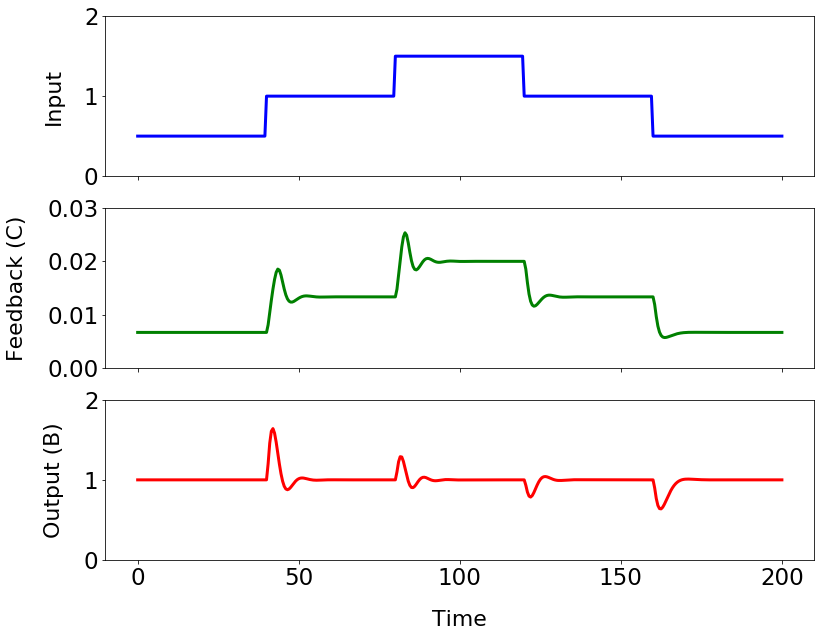

In [13]:
fig, ax = plt.subplots(3, 1, figsize = (12.7, 10))

#ax[0].set_title('Paper Simulation for Antithetical Integral Feedback', fontsize = 20)

ax[0].plot(time, sol_input_k1[:, 4], 'b', linewidth=3)
#ax[0].set_frame_on(50)

ax[0].set_xticks([0, 50, 100, 150, 200])
ax[0].set_xticklabels( () )

ax[0].set_ylim(0, 2)
ax[0].set_yticks([0, 1, 2])
plt.setp(ax[0].get_yticklabels(), fontsize=23)

ax[0].set_ylabel('Input', fontsize = 22, labelpad = 20)

####
ax[1].plot(time, sol_input_k1[:, 2], 'g', linewidth=3)

ax[1].set_xticks([0, 50, 100, 150, 200])
ax[1].set_xticklabels( () )

ax[1].set_ylim(0, 0.03)
ax[1].set_yticks([0, 0.01, 0.02, 0.03])
plt.setp(ax[1].get_yticklabels(), fontsize=23)

ax[1].set_ylabel('Feedback (C)', fontsize = 22, labelpad = 20)

####
ax[2].plot(time, sol_input_k1[:, 1], 'r', linewidth=3)

ax[2].set_xticks([0, 50, 100, 150, 200])

ax[2].set_ylim(0, 2)
ax[2].set_yticks([0, 1, 2])
plt.setp(ax[2].get_yticklabels(), fontsize=23)


plt.setp(ax[2].get_xticklabels(), fontsize=23)
ax[2].set_ylabel('Output (B)', fontsize = 22, labelpad = 20)

'''ax[3].plot(time, sol_input_k1[:, 0], 'm')
ax[3].set_ylabel('A', fontsize = 16)

ax[4].plot(time, sol_input_k1[:, 3], 'm')
ax[4].set_ylabel('D', fontsize = 16)'''
_ = ax[2].set_xlabel('Time', fontsize = 22, labelpad = 20)



El comportamiento del sistema, en lo que se refiere a la relación Input, Output, Feedback, es igual al observado anteriormente, tal y como se anunciaba en el paper. La única variable cuya dinámica varía de manera notable es la observada para A (el mRNA). La gráfica de la variable A muestra unos incrementos y descensos paralelos a los observados para la variable B (output). Esto tiene sentido si nos fijamos en las reacciones y en las ecuaciones diferenciales dado que el Input interacciona con el factor de transcripción que activa la producción de A. Así, el aumento en el Input conducirá a un aumento inmediato en la producción de mRNA que es rápidamente amortiguado por la retroalimentación negativa integral.

**Degradación de mRNA (k2)**

A continuación consideramos un caso en el que el Input favorece la degradación de mRNA A. Por lo tanto, las reacciones ahora serían:

$$
\begin{align}
&D \overset{k_1}{\longrightarrow} A \\
&A + Input \overset{k_2}{\longrightarrow} \varnothing \\
&A \overset{k_3}{\longrightarrow} B \\
&B \overset{k_4}{\longrightarrow} \varnothing \\
&B \overset{k_4}{\longrightarrow} C \\
&C + D \overset{k_5}{\longrightarrow} \varnothing \\
& \varnothing \overset{k_6}{\longrightarrow} D \\
\end{align}
$$

Las ecuaciones diferenciales que gobiernan el sistema serían:

$$
\begin{align}
\frac{dA}{dt} &= k_1 \cdot D - k_2 \cdot Input \cdot A \\ 
\frac{dB}{dt} &= k_3 \cdot A - k_4 \cdot B \\
\frac{dC}{dt} &= k_4 \cdot B- k_5 \cdot C \cdot D \\
\frac{dD}{dt} &= k_6 - k_5 \cdot C \cdot D \\
\end{align}
$$

Nuevamente, al cambiar las ecuaciones diferenciales, los valores iniciales establecidas antes para las variables ya no son de equilibrio. De nuevo fijamos B = 1 e Input = 0.5. A partir de ahí, recalculamos los valores de A, C y D para que el sistema esté en el equilibrio. Obtenemos A = 0.5, D = 0.75 y C = 0.00267.



In [14]:
k1 = 1
k2 = 3
k3 = 2
k4 = 1
k5 = 50
k6 = 1

A0 = 0.5
B0 = 1
C0 = 2/75 # Para no perder decimales
D0 = 0.75
Input = 0.5

u0 = [A0, B0, C0, D0]
p = [Input, k1, k2, k3, k4, k5, k6]

Definimos tiempo de simulación

In [15]:
tspan = (0.0, 200.0)
timestep = 0.5
time = np.linspace(tspan[0], tspan[1], int(1 + (tspan[1]-tspan[0])/timestep))

In [16]:
def ODE_Input_k2(u, t, Input, k1, k2, k3, k4, k5, k6):
    A, B, C, D = u
    
    dA = k1 * D - k2 * Input * A
    dB = k3 * A - k4 * B
    dC = k4 * B - k5 * C * D
    dD = k6 - k5 * C * D
    
    return np.array([dA, dB, dC, dD])

In [17]:
# Input_values = [(Input0, t0), (Input1, t1)...]
Input_values = [(0.5, 0), (1, 40), (1.5, 80), (1, 120), (0.5, 160)]

sol_input_k2 = Simul_Concatenate(ODE_func = ODE_Input_k2, Input_arr = Input_values, \
                              u0 = u0, p = p, tspan = tspan, timestep = timestep)

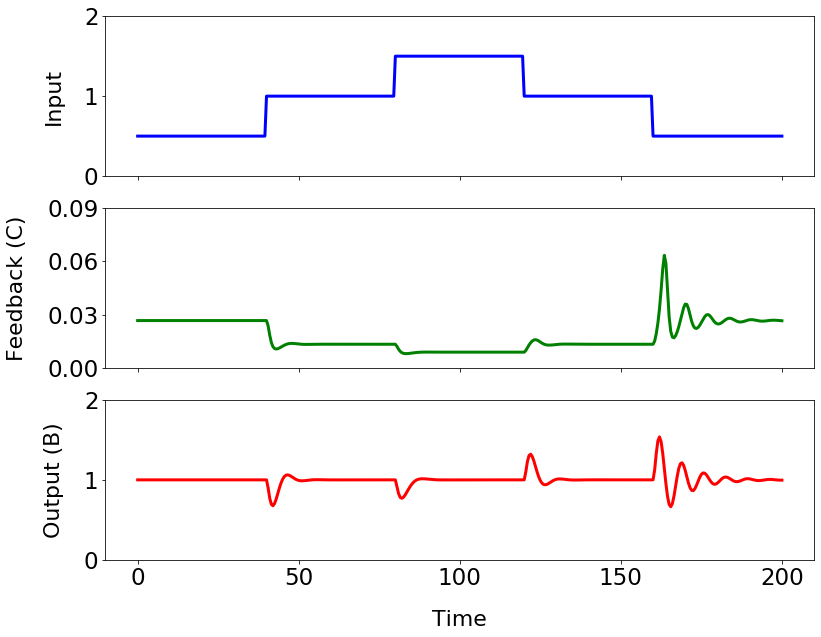

In [18]:
fig, ax = plt.subplots(3, 1, figsize = (12.7, 10))

#ax[0].set_title('Paper Simulation for Antithetical Integral Feedback', fontsize = 20)

ax[0].plot(time, sol_input_k2[:, 4], 'b', linewidth=3)
#ax[0].set_frame_on(50)

ax[0].set_xticks([0, 50, 100, 150, 200])
ax[0].set_xticklabels( () )

ax[0].set_ylim(0, 2)
ax[0].set_yticks([0, 1, 2])
plt.setp(ax[0].get_yticklabels(), fontsize=23)

ax[0].set_ylabel('Input', fontsize = 22, labelpad = 20)

####
ax[1].plot(time, sol_input_k2[:, 2], 'g', linewidth=3)

ax[1].set_xticks([0, 50, 100, 150, 200])
ax[1].set_xticklabels( () )

ax[1].set_ylim(0, 0.09)
ax[1].set_yticks([0, 0.03, 0.06, 0.09])
plt.setp(ax[1].get_yticklabels(), fontsize=23)

ax[1].set_ylabel('Feedback (C)', fontsize = 22, labelpad = 20)

####
ax[2].plot(time, sol_input_k2[:, 1], 'r', linewidth=3)

ax[2].set_xticks([0, 50, 100, 150, 200])

ax[2].set_ylim(0, 2)
ax[2].set_yticks([0, 1, 2])
plt.setp(ax[2].get_yticklabels(), fontsize=23)


plt.setp(ax[2].get_xticklabels(), fontsize=23)
ax[2].set_ylabel('Output (B)', fontsize = 22, labelpad = 20)

'''ax[3].plot(time, sol_input_k2[:, 0], 'm')
ax[3].set_ylabel('A', fontsize = 16)

ax[4].plot(time, sol_input_k2[:, 3], 'm')
ax[4].set_ylabel('D', fontsize = 16)'''
_ = ax[2].set_xlabel('Time', fontsize = 22, labelpad = 20)


**Degradación de proteína (k4)**

A continuación consideramos un caso en el que el Input favorece la degradación de proteína B. Por lo tanto, las reacciones ahora serían:

$$
\begin{align}
&D \overset{k_1}{\longrightarrow} A \\
&A \overset{k_2}{\longrightarrow} \varnothing \\
&A \overset{k_3}{\longrightarrow} B \\
&B + Input \overset{k_4}{\longrightarrow} \varnothing \\
&B \overset{k_4}{\longrightarrow} C \\
&C + D \overset{k_5}{\longrightarrow} \varnothing \\
& \varnothing \overset{k_6}{\longrightarrow} D \\
\end{align}
$$

Las ecuaciones diferenciales que gobiernan el sistema serían:

$$
\begin{align}
\frac{dA}{dt} &= k_1 \cdot D - k_2 \cdot A \\ 
\frac{dB}{dt} &= k_3 \cdot A - k_4 \cdot Input \cdot B \\
\frac{dC}{dt} &= k_4 \cdot B- k_5 \cdot C \cdot D \\
\frac{dD}{dt} &= k_6 - k_5 \cdot C \cdot D \\
\end{align}
$$

Nuevamente, al cambiar las ecuaciones diferenciales, los valores iniciales establecidas antes para las variables ya no son de equilibrio. De nuevo fijamos B = 1 e Input = 0.5. A partir de ahí, recalculamos los valores de A, C y D para que el sistema esté en el equilibrio. Obtenemos A = 0.25, D = 0.75 y C = 0.00267. Con respecto al anterior, solo cambia el valor de A.

In [19]:
k1 = 1
k2 = 3
k3 = 2
k4 = 1
k5 = 50
k6 = 1

A0 = 0.25
B0 = 1
C0 = 2/75 # Para no perder decimales
D0 = 0.75
Input = 0.5

u0 = [A0, B0, C0, D0]
p = [Input, k1, k2, k3, k4, k5, k6]

In [20]:
tspan = (0.0, 200.0)
timestep = 0.5
time = np.linspace(tspan[0], tspan[1], int(1 + (tspan[1]-tspan[0])/timestep))

In [21]:
def ODE_Input_k4(u, t, Input, k1, k2, k3, k4, k5, k6):
    A, B, C, D = u
    
    dA = k1 * D - k2 * A
    dB = k3 * A - k4 * Input * B
    dC = k4 * B - k5 * C * D
    dD = k6 - k5 * C * D
    
    return np.array([dA, dB, dC, dD])

In [22]:
# Input_values = [(Input0, t0), (Input1, t1)...]
Input_values = [(0.5, 0), (1, 40), (1.5, 80), (1, 120), (0.5, 160)]

sol_input_k4 = Simul_Concatenate(ODE_func = ODE_Input_k4, Input_arr = Input_values, \
                              u0 = u0, p = p, tspan = tspan, timestep = timestep)

"\nfig, ax = plt.subplots(5, 1, figsize = (14, 18))\n\nax[0].set_title('Simulación considerando que el Input estimula degradación de B', fontsize = 20)\n\nax[0].plot(time, sol_input_k4[:, 4], 'b')\nax[0].set_ylabel('Input', fontsize = 16)\n\nax[1].plot(time, sol_input_k4[:, 2], 'g')\nax[1].set_ylabel('Feedback (C)', fontsize = 16)\n\nax[2].plot(time, sol_input_k4[:, 1], 'r')\nax[2].set_ylabel('Output (B)', fontsize = 16)\n\nax[3].plot(time, sol_input_k4[:, 0], 'm')\nax[3].set_ylabel('A', fontsize = 16)\n\nax[4].plot(time, sol_input_k4[:, 3], 'm')\nax[4].set_ylabel('D', fontsize = 16)\n_ = ax[4].set_xlabel('Time', fontsize = 16)"

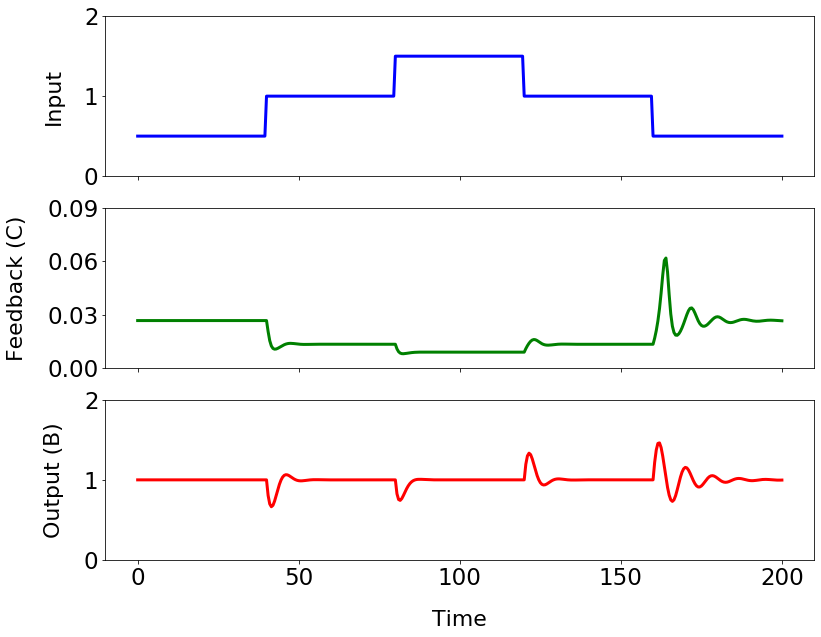

In [23]:
fig, ax = plt.subplots(3, 1, figsize = (12.7, 10))

#ax[0].set_title('Paper Simulation for Antithetical Integral Feedback', fontsize = 20)

ax[0].plot(time, sol_input_k4[:, 4], 'b', linewidth=3)
#ax[0].set_frame_on(50)

ax[0].set_xticks([0, 50, 100, 150, 200])
ax[0].set_xticklabels( () )

ax[0].set_ylim(0, 2)
ax[0].set_yticks([0, 1, 2])
plt.setp(ax[0].get_yticklabels(), fontsize=23)

ax[0].set_ylabel('Input', fontsize = 22, labelpad = 20)

####
ax[1].plot(time, sol_input_k4[:, 2], 'g', linewidth=3)

ax[1].set_xticks([0, 50, 100, 150, 200])
ax[1].set_xticklabels( () )

ax[1].set_ylim(0, 0.09)
ax[1].set_yticks([0, 0.03, 0.06, 0.09])
plt.setp(ax[1].get_yticklabels(), fontsize=23)

ax[1].set_ylabel('Feedback (C)', fontsize = 22, labelpad = 20)

####
ax[2].plot(time, sol_input_k4[:, 1], 'r', linewidth=3)

ax[2].set_xticks([0, 50, 100, 150, 200])

ax[2].set_ylim(0, 2)
ax[2].set_yticks([0, 1, 2])
plt.setp(ax[2].get_yticklabels(), fontsize=23)


plt.setp(ax[2].get_xticklabels(), fontsize=23)
ax[2].set_ylabel('Output (B)', fontsize = 22, labelpad = 20)

'''ax[3].plot(time, sol_input_k4[:, 0], 'm')
ax[3].set_ylabel('A', fontsize = 16)

ax[4].plot(time, sol_input_k4[:, 3], 'm')
ax[4].set_ylabel('D', fontsize = 16)'''
_ = ax[2].set_xlabel('Time', fontsize = 22, labelpad = 20)

'''
fig, ax = plt.subplots(5, 1, figsize = (14, 18))

ax[0].set_title('Simulación considerando que el Input estimula degradación de B', fontsize = 20)

ax[0].plot(time, sol_input_k4[:, 4], 'b')
ax[0].set_ylabel('Input', fontsize = 16)

ax[1].plot(time, sol_input_k4[:, 2], 'g')
ax[1].set_ylabel('Feedback (C)', fontsize = 16)

ax[2].plot(time, sol_input_k4[:, 1], 'r')
ax[2].set_ylabel('Output (B)', fontsize = 16)

ax[3].plot(time, sol_input_k4[:, 0], 'm')
ax[3].set_ylabel('A', fontsize = 16)

ax[4].plot(time, sol_input_k4[:, 3], 'm')
ax[4].set_ylabel('D', fontsize = 16)
_ = ax[4].set_xlabel('Time', fontsize = 16)'''

Cuando el Input actúa sobre la degradación de mRNA o de proteína se obtienen resultados interesantes. Por un lado, como era de esperar, el aumento en el input produce una reducción temporal de la señal. Así, si aumenta la degradación de mRNA (A) o de proteína (B), se reduce la cantidad de B y por lo tanto de output. Rápidamente el output vuelve al estado basal por acción del Feedback. No obstante, tal y como se mencionaba en el paper, bajo ciertas circunstancias el sistema puede sufrir oscilaciones (en algunos casos sin recuperar el estado basal). Eso es lo que observamos en nuestros modelos tras el último cambio de señal.

En el mismo paper se explicaba que implementaciones estocásticas podían eliminar esas oscilaciones. A continuación vamos a realizar dichas implementaciones estocásticas para ver qué sucede.

### Simulación con implementaciones estocásticas

**Modelo del Paper**

Parámetros de Paper

In [24]:
k1 = 1
k2 = 3
k3 = 2
k4 = 1
k5 = 50
k6 = 1

A0 = 1
B0 = 1
C0 = 1/150 # Para no perder decimales
D0 = 3
Input = 0.5

u0 = [A0, B0, C0, D0]
p = [Input, k1, k2, k3, k4, k5, k6]

Tiempo de simulación

In [25]:
tspan = (0.0, 200.0)
timestep = 0.01
time = np.linspace(tspan[0], tspan[1], int(1 + (tspan[1]-tspan[0])/timestep))

Redefinimos las funciones con las ecuaciones diferenciales y añadimos una función de ruido para poder hacer la simulación estocástica con `sdeint`

In [26]:
def SDE_Paper(u, t):
    A, B, C, D, Input = u
    
    dA = k1 * D - k2 * A
    dB = k3 * Input * A - k4 * B
    dC = k4 * B - k5 * C * D
    dD = k6 - k5 * C * D
    dInput = 0
    
    return np.array([dA, dB, dC, dD, dInput])

def NoiseFunction(u, t):
    return np.diag([0.01, 0.01, 0.01, 0.01, 0.01])

In [27]:
# Input_values = [(Input0, t0), (Input1, t1)...]
Input_values = [(0.5, 0), (1, 40), (1.5, 80), (1, 120), (0.5, 160)]

sol_paper_sde = Simul_Concatenate(SDE = True, ODE_func = SDE_Paper, Input_arr = Input_values, u0 = u0, \
                      p = p, tspan = tspan, timestep = timestep)

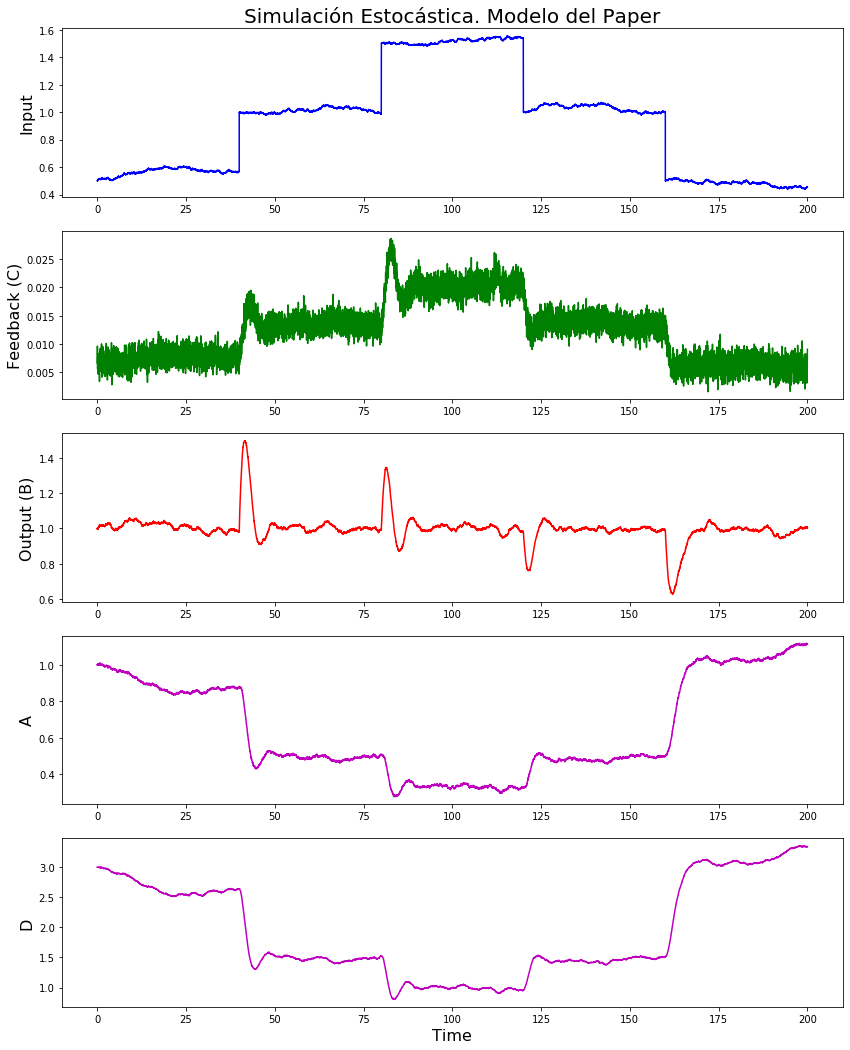

In [28]:
fig, ax = plt.subplots(5, 1, figsize = (14, 18))

ax[0].set_title('Simulación Estocástica. Modelo del Paper', fontsize = 20)

ax[0].plot(time, sol_paper_sde[:, 4], 'b')
ax[0].set_ylabel('Input', fontsize = 16)

ax[1].plot(time, sol_paper_sde[:, 2], 'g')
ax[1].set_ylabel('Feedback (C)', fontsize = 16)

ax[2].plot(time, sol_paper_sde[:, 1], 'r')
ax[2].set_ylabel('Output (B)', fontsize = 16)

ax[3].plot(time, sol_paper_sde[:, 0], 'm')
ax[3].set_ylabel('A', fontsize = 16)

ax[4].plot(time, sol_paper_sde[:, 3], 'm')
ax[4].set_ylabel('D', fontsize = 16)
_ = ax[4].set_xlabel('Time', fontsize = 16)

**Simulación Estocástica. Input actuando sobre degradación de mRNA**

In [29]:
A0 = 0.5
B0 = 1
C0 = 2/75 # Para no perder decimales
D0 = 0.75
Input = 0.5

u0 = [A0, B0, C0, D0]
p = [Input, k1, k2, k3, k4, k5, k6]

Definimos tiempo de simulación

In [30]:
tspan = (0.0, 200.0)
timestep = 0.01
time = np.linspace(tspan[0], tspan[1], int(1 + (tspan[1]-tspan[0])/timestep))

In [31]:
def SDE_Input_k2(u, t):
    A, B, C, D, Input = u
    
    dA = k1 * D - k2 * Input * A
    dB = k3 * A - k4 * B
    dC = k4 * B - k5 * C * D
    dD = k6 - k5 * C * D
    dInput = 0
    
    return np.array([dA, dB, dC, dD, dInput])

In [32]:
# Input_values = [(Input0, t0), (Input1, t1)...]
Input_values = [(0.5, 0), (1, 40), (1.5, 80), (1, 120), (0.5, 160)]

sol_input_k2_sde = Simul_Concatenate(SDE=True, ODE_func = SDE_Input_k2, Input_arr = Input_values, \
                              u0 = u0, p = p, tspan = tspan, timestep = timestep)

"fig, ax = plt.subplots(5, 1, figsize = (14, 18))\n\nax[0].set_title('Simulación Estocástica. El Input estimula degradación de mRNA', fontsize = 20)\n\nax[0].plot(time, sol_input_k2_sde[:, 4], 'b')\nax[0].set_ylabel('Input', fontsize = 16)\n\nax[1].plot(time, sol_input_k2_sde[:, 2], 'g')\nax[1].set_ylabel('Feedback (C)', fontsize = 16)\n\nax[2].plot(time, sol_input_k2_sde[:, 1], 'r')\nax[2].set_ylabel('Output (B)', fontsize = 16)\n\nax[3].plot(time, sol_input_k2_sde[:, 0], 'm')\nax[3].set_ylabel('A', fontsize = 16)\n\nax[4].plot(time, sol_input_k2_sde[:, 3], 'm')\nax[4].set_ylabel('D', fontsize = 16)\n_ = ax[4].set_xlabel('Time', fontsize = 16)"

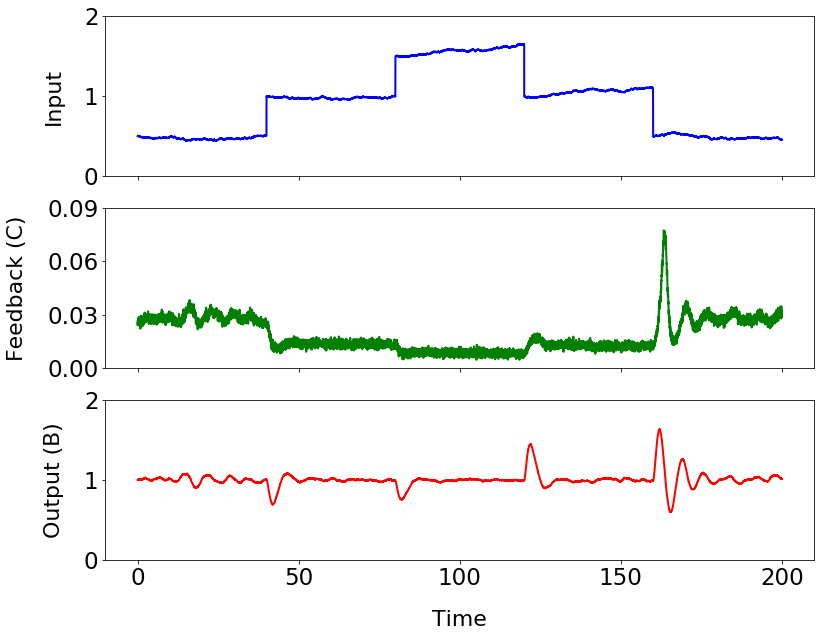

In [42]:
fig, ax = plt.subplots(3, 1, figsize = (12.7, 10))

#ax[0].set_title('Paper Simulation for Antithetical Integral Feedback', fontsize = 20)

ax[0].plot(time, sol_input_k2_sde[:, 4], 'b', linewidth=2)
#ax[0].set_frame_on(50)

ax[0].set_xticks([0, 50, 100, 150, 200])
ax[0].set_xticklabels( () )

ax[0].set_ylim(0, 2)
ax[0].set_yticks([0, 1, 2])
plt.setp(ax[0].get_yticklabels(), fontsize=23)

ax[0].set_ylabel('Input', fontsize = 22, labelpad = 20)

####
ax[1].plot(time, sol_input_k2_sde[:, 2], 'g', linewidth=2)

ax[1].set_xticks([0, 50, 100, 150, 200])
ax[1].set_xticklabels( () )

ax[1].set_ylim(0, 0.09)
ax[1].set_yticks([0, 0.03, 0.06, 0.09])
plt.setp(ax[1].get_yticklabels(), fontsize=23)

ax[1].set_ylabel('Feedback (C)', fontsize = 22, labelpad = 20)

####
ax[2].plot(time, sol_input_k2_sde[:, 1], 'r', linewidth=2)

ax[2].set_xticks([0, 50, 100, 150, 200])

ax[2].set_ylim(0, 2)
ax[2].set_yticks([0, 1, 2])
plt.setp(ax[2].get_yticklabels(), fontsize=23)


plt.setp(ax[2].get_xticklabels(), fontsize=23)
ax[2].set_ylabel('Output (B)', fontsize = 22, labelpad = 20)

'''ax[3].plot(time, sol_input_k2_sde[:, 0], 'm')
ax[3].set_ylabel('A', fontsize = 16)

ax[4].plot(time, sol_input_k2_sde[:, 3], 'm')
ax[4].set_ylabel('D', fontsize = 16)'''
_ = ax[2].set_xlabel('Time', fontsize = 22, labelpad = 20)


"""fig, ax = plt.subplots(5, 1, figsize = (14, 18))

ax[0].set_title('Simulación Estocástica. El Input estimula degradación de mRNA', fontsize = 20)

ax[0].plot(time, sol_input_k2_sde[:, 4], 'b')
ax[0].set_ylabel('Input', fontsize = 16)

ax[1].plot(time, sol_input_k2_sde[:, 2], 'g')
ax[1].set_ylabel('Feedback (C)', fontsize = 16)

ax[2].plot(time, sol_input_k2_sde[:, 1], 'r')
ax[2].set_ylabel('Output (B)', fontsize = 16)

ax[3].plot(time, sol_input_k2_sde[:, 0], 'm')
ax[3].set_ylabel('A', fontsize = 16)

ax[4].plot(time, sol_input_k2_sde[:, 3], 'm')
ax[4].set_ylabel('D', fontsize = 16)
_ = ax[4].set_xlabel('Time', fontsize = 16)"""

**Simulación estocástica. Input actuando sobre degradación de proteína**

In [34]:
A0 = 0.25
B0 = 1
C0 = 2/75 # Para no perder decimales
D0 = 0.75
Input = 0.5

u0 = [A0, B0, C0, D0]
p = [Input, k1, k2, k3, k4, k5, k6]

Definimos tiempo de simulación

In [35]:
tspan = (0.0, 200.0)
timestep = 0.01
time = np.linspace(tspan[0], tspan[1], int(1 + (tspan[1]-tspan[0])/timestep))

In [36]:
def SDE_Input_k4(u, t):
    A, B, C, D, Input = u
    
    dA = k1 * D - k2 * A
    dB = k3 * A - k4 * Input * B
    dC = k4 * B - k5 * C * D
    dD = k6 - k5 * C * D
    dInput = 0
    
    return np.array([dA, dB, dC, dD, dInput])

In [37]:
# Input_values = [(Input0, t0), (Input1, t1)...]
Input_values = [(0.5, 0), (1, 40), (1.5, 80), (1, 120), (0.5, 160)]

sol_input_k4_sde = Simul_Concatenate(SDE=True, ODE_func = SDE_Input_k4, Input_arr = Input_values, \
                              u0 = u0, p = p, tspan = tspan, timestep = timestep)

"fig, ax = plt.subplots(5, 1, figsize = (14, 18))\n\nax[0].set_title('Simulación estocástica. Input estimula degradación de B', fontsize = 20)\n\nax[0].plot(time, sol_input_k4_sde[:, 4], 'b')\nax[0].set_ylabel('Input', fontsize = 16)\n\nax[1].plot(time, sol_input_k4_sde[:, 2], 'g')\nax[1].set_ylabel('Feedback (C)', fontsize = 16)\n\nax[2].plot(time, sol_input_k4_sde[:, 1], 'r')\nax[2].set_ylabel('Output (B)', fontsize = 16)\n\nax[3].plot(time, sol_input_k4_sde[:, 0], 'm')\nax[3].set_ylabel('A', fontsize = 16)\n\nax[4].plot(time, sol_input_k4_sde[:, 3], 'm')\nax[4].set_ylabel('D', fontsize = 16)\n_ = ax[4].set_xlabel('Time', fontsize = 16)"

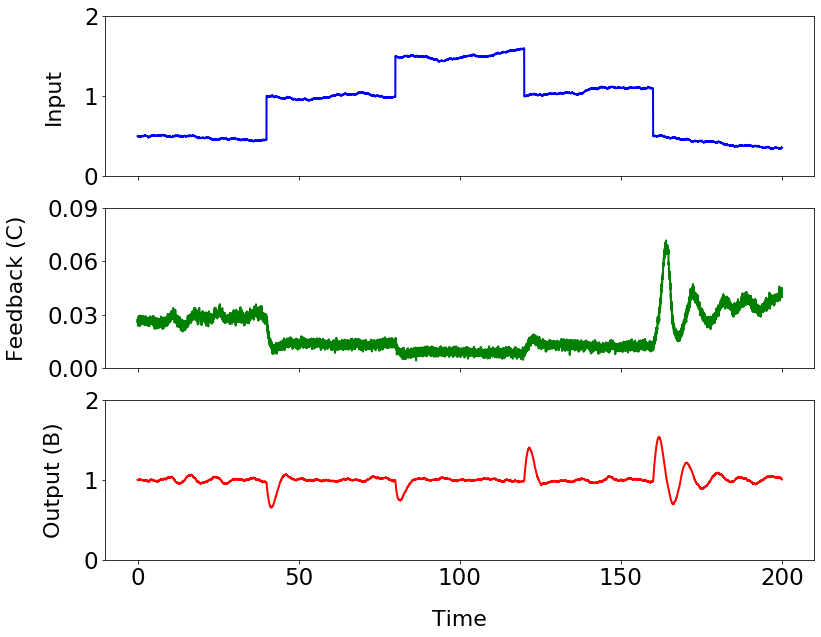

In [43]:
fig, ax = plt.subplots(3, 1, figsize = (12.7, 10))

#ax[0].set_title('Paper Simulation for Antithetical Integral Feedback', fontsize = 20)

ax[0].plot(time, sol_input_k4_sde[:, 4], 'b', linewidth=2)
#ax[0].set_frame_on(50)

ax[0].set_xticks([0, 50, 100, 150, 200])
ax[0].set_xticklabels( () )

ax[0].set_ylim(0, 2)
ax[0].set_yticks([0, 1, 2])
plt.setp(ax[0].get_yticklabels(), fontsize=23)

ax[0].set_ylabel('Input', fontsize = 22, labelpad = 20)

####
ax[1].plot(time, sol_input_k4_sde[:, 2], 'g', linewidth=2)

ax[1].set_xticks([0, 50, 100, 150, 200])
ax[1].set_xticklabels( () )

ax[1].set_ylim(0, 0.09)
ax[1].set_yticks([0, 0.03, 0.06, 0.09])
plt.setp(ax[1].get_yticklabels(), fontsize=23)

ax[1].set_ylabel('Feedback (C)', fontsize = 22, labelpad = 20)

####
ax[2].plot(time, sol_input_k4_sde[:, 1], 'r', linewidth=2)

ax[2].set_xticks([0, 50, 100, 150, 200])

ax[2].set_ylim(0, 2)
ax[2].set_yticks([0, 1, 2])
plt.setp(ax[2].get_yticklabels(), fontsize=23)


plt.setp(ax[2].get_xticklabels(), fontsize=23)
ax[2].set_ylabel('Output (B)', fontsize = 22, labelpad = 20)

'''ax[3].plot(time, sol_input_k4_sde[:, 0], 'm')
ax[3].set_ylabel('A', fontsize = 16)

ax[4].plot(time, sol_input_k4_sde[:, 3], 'm')
ax[4].set_ylabel('D', fontsize = 16)'''
_ = ax[2].set_xlabel('Time', fontsize = 22, labelpad = 20)

"""fig, ax = plt.subplots(5, 1, figsize = (14, 18))

ax[0].set_title('Simulación estocástica. Input estimula degradación de B', fontsize = 20)

ax[0].plot(time, sol_input_k4_sde[:, 4], 'b')
ax[0].set_ylabel('Input', fontsize = 16)

ax[1].plot(time, sol_input_k4_sde[:, 2], 'g')
ax[1].set_ylabel('Feedback (C)', fontsize = 16)

ax[2].plot(time, sol_input_k4_sde[:, 1], 'r')
ax[2].set_ylabel('Output (B)', fontsize = 16)

ax[3].plot(time, sol_input_k4_sde[:, 0], 'm')
ax[3].set_ylabel('A', fontsize = 16)

ax[4].plot(time, sol_input_k4_sde[:, 3], 'm')
ax[4].set_ylabel('D', fontsize = 16)
_ = ax[4].set_xlabel('Time', fontsize = 16)"""

La simulación estocástica (con ruido) no logramos eliminar las oscilaciones que aparecen en el último cambio de señal de input, especialmente en el caso en el que el Input actúa sobre la degradación del mRNA. Sin embargo, en el modelo del paper vemos que la adaptación del sistema funciona perfectamente pese al ruido introducido durante la simulación. Lo mismo podríamos decir de los dos últimos.

### Cambios en los parámetros modificables (k1, k2, k3 y k5). Modelo del Paper

In [39]:
# Constantes cinéticas
k1 = 1
k2 = 3
k3 = 2
k4 = 1
k5 = 50
k6 = 1

# Valores iniciales de las variables
A0 = 1
B0 = 1
C0 = 1/150 # Para no perder decimales
D0 = 3
Input = 0.5

# Arrays pasados a odeint
u0 = [A0, B0, C0, D0]

# Tiempo de la simulación
tspan = (0.0, 200.0)
timestep = 0.01
time = np.linspace(tspan[0], tspan[1], int(1 + (tspan[1]-tspan[0])/timestep))

**$k_1, k_2, k_3, k_5$: Oscilación y Rapidez en la adaptación**

Una reducción excesiva del ratio $\frac{k2}{k3}$ o $\frac{k2}{k1}$ (e.g. 1, 1, 1) hace que el sistema se vuelva altamente oscilatorio, mientras que valores altos para ambas razones evitan las oscilaciones. Esto lo comprobamos en los modelos en los cuales el input actuaba sobre la degradación del mRNA y de la proteína B. La oscilación que aparecía en estos modelos puede reducirse o incluso eliminarse aumentando el parámetro k2 del modelo, *ceteris paribus*.

Si ambos ratios son excesivamente elevados la adaptación es muy lenta (1, 10, 1).

Dicho eso, el sistema es bastante robusto a cambios en los parámetros k1, k2, k3 y k5, mostrando una alta capacidad adaptativa. Esto es especialmente notable en el caso del parámetro k5, que puede adoptar prácticamente cualquier valor.

La clave, entonces, para el funcionamiento del sistema es la relación entre k1, k2 y k3. Así, k2 debe ser algo mayor que k1 y que k3. Si no es lo suficientemente elevado aparecen oscilaciones. Si es demasiado elevado, la adaptación es lenta.

Otro aspecto interesante es que el estado basal es independiente de los valores de los parámetros k1, k2, k3 y k5. Según se menciona en el paper, dicho estado basal depende de los parámetros k4 y k6, que pasamos a analizar.

**k4 y k6: Intensidad de la señal**

El ratio $\frac{k6}{k4}$ determina la intensidad de la señal del output. Su orden de maginud debe ser igual o superior al de los otros parámetros. De lo contrario la adaptación es lenta o inexistente.

In [80]:
sol_paper[-1, :]

array([7.99823010e+00, 1.99950889e+00, 3.33320353e-03, 2.39950409e+01,
       5.00000000e-01])

"\nfig, ax = plt.subplots(3, 1, figsize = (14, 10))\n\nax[0].set_title('Paper Simulation for Antithetical Integral Feedback', fontsize = 20)\n\nax[0].plot(time, sol_paper[:, 4], 'b')\nax[0].set_ylabel('Input', fontsize = 16)\n\nax[1].plot(time, sol_paper[:, 2], 'g')\nax[1].set_ylabel('Feedback (C)', fontsize = 16)\n\nax[2].plot(time, sol_paper[:, 1], 'r')\n_ = ax[2].set_ylabel('Output (B)', fontsize = 16)\n\nprint(f'Cantidad final de B (output): {sol_paper[-1, 1]}')"

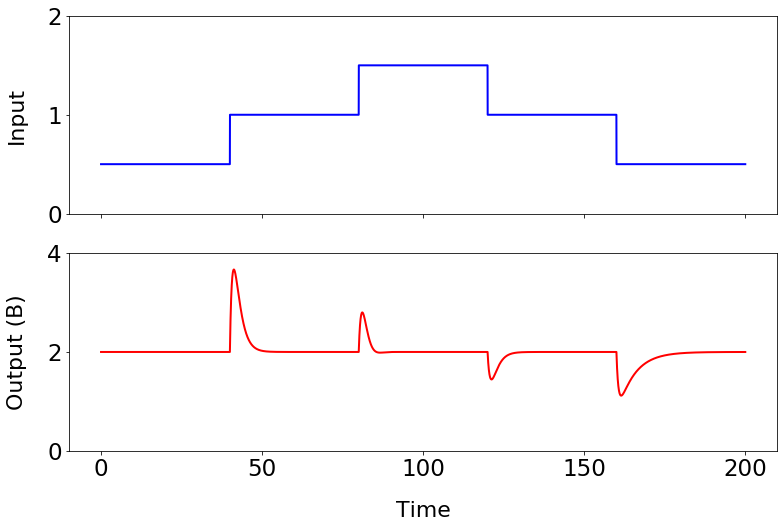

In [81]:
################
k1 = 1
k2 = 3
k3 = 1
k5 = 50
################

################
k4 = 2
k6 = 4
################

# Valores iniciales de las variables
#################
A0 = 8
B0 = 2
C0 = 0.00333 # Para no perder decimales
D0 = 24
#################

p = [Input, k1, k2, k3, k4, k5, k6]

# Arrays pasados a odeint
u0 = [A0, B0, C0, D0]

# Input_values = [(Input0, t0), (Input1, t1)...]
Input_values = [(0.5, 0), (1, 40), (1.5, 80), (1, 120), (0.5, 160)]

sol_paper = Simul_Concatenate(ODE_func = ODE_Paper, Input_arr = Input_values, u0 = u0, p = p, tspan = tspan, timestep = timestep)

# sol_paper = Simul_Concatenate(SDE = True, ODE_func = SDE_Paper, Input_arr = Input_values, u0 = u0, p = p, tspan = tspan, timestep = timestep)



fig, ax = plt.subplots(2, 1, figsize = (12.7, 8))

#ax[0].set_title('Paper Simulation for Antithetical Integral Feedback', fontsize = 20)

ax[0].plot(time, sol_paper[:, 4], 'b', linewidth=2)
#ax[0].set_frame_on(50)

ax[0].set_xticks([0, 50, 100, 150, 200])
ax[0].set_xticklabels( () )

ax[0].set_ylim(0, 2)
ax[0].set_yticks([0, 1, 2])
plt.setp(ax[0].get_yticklabels(), fontsize=23)

ax[0].set_ylabel('Input', fontsize = 22, labelpad = 20)

####
'''ax[1].plot(time, sol_paper[:, 2], 'g', linewidth=2)

ax[1].set_xticks([0, 50, 100, 150, 200])
ax[1].set_xticklabels( () )

ax[1].set_ylim(0, 0.03)
ax[1].set_yticks([0, 0.01, 0.02, 0.03])
plt.setp(ax[1].get_yticklabels(), fontsize=23)

ax[1].set_ylabel('Feedback (C)', fontsize = 22, labelpad = 20)'''

####
ax[1].plot(time, sol_paper[:, 1], 'r', linewidth=2)

ax[1].set_xticks([0, 50, 100, 150, 200])

ax[1].set_ylim(0, 4)
ax[1].set_yticks([0, 2, 4])
plt.setp(ax[1].get_yticklabels(), fontsize=23)


plt.setp(ax[1].get_xticklabels(), fontsize=23)
ax[1].set_ylabel('Output (B)', fontsize = 22, labelpad = 20)

'''ax[3].plot(time, sol_input_k4_sde[:, 0], 'm')
ax[3].set_ylabel('A', fontsize = 16)

ax[4].plot(time, sol_input_k4_sde[:, 3], 'm')
ax[4].set_ylabel('D', fontsize = 16)'''
_ = ax[1].set_xlabel('Time', fontsize = 22, labelpad = 20)



"""
fig, ax = plt.subplots(3, 1, figsize = (14, 10))

ax[0].set_title('Paper Simulation for Antithetical Integral Feedback', fontsize = 20)

ax[0].plot(time, sol_paper[:, 4], 'b')
ax[0].set_ylabel('Input', fontsize = 16)

ax[1].plot(time, sol_paper[:, 2], 'g')
ax[1].set_ylabel('Feedback (C)', fontsize = 16)

ax[2].plot(time, sol_paper[:, 1], 'r')
_ = ax[2].set_ylabel('Output (B)', fontsize = 16)

print(f'Cantidad final de B (output): {sol_paper[-1, 1]}')"""

### Ejemplos en Biología

**Factor de Crecimiento Epidérmico (EGF)**

La Retroalimentación Integral Antitética se puede encontrar en la respuesta desecencadenada por el factor de crecimiento epidérmico, al igual que los otros modelos descritos en el paper. Así, la unión de EGF a su receptor conduce a la expresión de una serie de genes, entre los cuales encontramos el codificante de la proteína Jun (sería la D del modelo). Jun es uno de los componentes del factor de transcripción AP-1 (B, output o señal en el modelo) que favorece la expresión de una gran variedad de genes. Entre las proteínas activadas por AP-1 encontramos JunB (sería la C del modelo), la cual se une a Jun (D), bloqueando su capacidad para formar AP-1 y activar sus genes asociados.

**Expresión de HouseKeeping genes mediado por $\sigma^{70}$**

Otro ejemplo en el que posiblemente funcione este tipo de regulación lo encontramos en procariotas (ejemplo usado en el paper de Corentin Briat, aunque afirman que no está aún demostrado). Así, el factor de transcripción $\sigma^{70}$ (D) es uno de los componentes auxiliares de la RNA polimerasa (B), favoreciendo la expresión de los housekeeping genes. Entre los genes expresados encontramos el factor anti-sigma (Rsd) (C) que se une con bastante afinidad a $\sigma^{70}$, evitando la formación del complejo RNAP. 

**NF-$\kappa$B**

En la señalización mediada por NF-$\kappa$B puede ser que también aparezca esta regulación. En esta señalización, el output generado muestra un comportamiento oscilatorio, que se había mostrado como una de las amenazas del modelo de retroalimentación integral antitético. La oscilación en este caso no sería un defecto del sistema, sino reflejo de una propiedad fisiológica.